## Amazon Cell Phone Review Analysis and Rating Predictions

In this project, we are going to analyze amazon reviews and predict the rating using the reviews.
This dataset focuses on both unlocked and locked carriers, and scoped on ten brands: ASUS, Apple, Google, HUAWEI, Motorola, Nokia, OnePlus, Samsung, Sony, and Xiaomi. 

There are two files in this dataset: cell phone information data and the review data. The dataset can be downloaded from __[here.](https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews)__ We will be working on 75,548 reviews. cellphone_items file contains information about brand, cell phone title, rating, number of reviews, prices and cellphone_reviews file has information about the rating, review title and review text. We will merge both files on the unique number for each phone - asin present in both the files. 

This analysis will help us understand the popular cell phone brands, their model ratings and reviews which you can use when you consider buying a new cell phone. I have choosen the top two most popular brands - Samsung and Apple for detailed analysis. It can be extended to other brands.
Cell phone brand companies can look at the popular review words and work on the negative feedbacks to improve user satisfaction. 

We are going to work on the below points:
1. Review Analysis
2. Popular Review Words
3. Brand-wise Review Rating
4. Date-wise Review Count
5. Predicting Rating Based on Reviews

### Summary of Results
1. Majority of the reviews have less than 100 words.
2. Samsung and Apple are the two most popular cell phone brands.
3. Users are using words like great, love, brand new, works great for positive experiences, while words like issue, problem, bad, still for negative experiences.
4. Samsung needs to work on issues like phone shutdown, returns, sound, phone reset, overall working and restart. Samsung users are happy with the overall phone, camera, features, screen.
5. Apple needs to work on battery, refurbished model issues, scratches, screen issues, returns, sending correct models. Apple users are satisfied with the overall product.
6. Majority of popular 20 frequent words are positive.
7. Xiaomi has highest rating among all the brands. Mototola, Samsung and ASUS have most of the ratings above 3, while brands like Nokia, Sony, Apple and Google have ratings distributed from 2 to 5. 
8. Review count has consistently increased from 2010 to August 2019 and reduced after that. Maximum number of reviews are seen in July 2019.
9. Best accuracy(72%) in predicting rating using reviews was obtained with the Linear SVC Model.

### Read Data

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode()

#Import warnings filter
from warnings import simplefilter
#Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Read data from both the csv files
cellphone_items = pd.read_csv("amazon-cellphone-items.csv")
cellphone_reviews = pd.read_csv("amazon-cellphone-reviews.csv")

In [3]:
#Quick look at the data
cellphone_items.head()

asin     brand                                              title  \
0  B0000SX2UC     Nokia  Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...   
1  B0009N5L7K  Motorola                                Motorola I265 phone   
2  B000SKTZ0S  Motorola  MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...   
3  B00198M12M     Nokia  Nokia 6500 Slide Black/silver Unlocked Cell Phone   
4  B001AO4OUC  Motorola              Motorola i335 Cell Phone Boost Mobile   

                                                 url  \
0  https://www.amazon.com/Dual-Band-Tri-Mode-Acti...   
1  https://www.amazon.com/Motorola-i265-I265-phon...   
2  https://www.amazon.com/MOTOROLA-C168i-CINGULAR...   
3  https://www.amazon.com/Nokia-6500-Slide-silver...   
4  https://www.amazon.com/Motorola-i335-Phone-Boo...   

                                               image  rating  \
0  https://m.media-amazon.com/images/I/2143EBQ210...     3.0   
1  https://m.media-amazon.com/images/I/419WBAVDAR...     2.9   
2  https://m.media-amazon.com/images/I/71b+q3ydkI...     2.6   
3  https://m.media-amazon.com/images/I/41ss4HpLkL...     2.4   
4  https://m.media-amazon.com/images/I/710UO8gdT+...     3.3   

                                           reviewUrl  totalReviews  prices  
0  https://www.amazon.com/product-reviews/B0000SX2UC            14     NaN  
1  https://www.amazon.com/product-reviews/B0009N5L7K             7  $49.95  
2  https://www.amazon.com/product-reviews/B000SKTZ0S            22     NaN  
3  https://www.amazon.com/product-reviews/B00198M12M             5     NaN  
4  https://www.amazon.com/product-reviews/B001AO4OUC            21     NaN

In [4]:
#Rename column names
cellphone_items.rename({'rating' : 'product_rating', 
                        'title' : 'phone_title', 
                        'image' : 'product_image_url', 
                        'reviewUrl' : 'product_review_url', 
                        'totalReviews' : 'total_reviews'}, axis = 1, inplace = True)

In [5]:
#Quick look at the data
cellphone_reviews.head()

asin           name  rating               date  verified  \
0  B0000SX2UC          Janet       3   October 11, 2005     False   
1  B0000SX2UC     Luke Wyatt       1    January 7, 2004     False   
2  B0000SX2UC         Brooke       5  December 30, 2003     False   
3  B0000SX2UC  amy m. teague       3     March 18, 2004     False   
4  B0000SX2UC  tristazbimmer       4    August 28, 2005     False   

                                          title  \
0                   Def not best, but not worst   
1                   Text Messaging Doesn't Work   
2                               Love This Phone   
3                       Love the Phone, BUT...!   
4  Great phone service and options, lousy case!   

                                                body  helpfulVotes  
0  I had the Samsung A600 for awhile which is abs...           1.0  
1  Due to a software issue between Nokia and Spri...          17.0  
2  This is a great, reliable phone. I also purcha...           5.0  
3  I love the phone and all, because I really did...           1.0  
4  The phone has been great for every purpose it ...           1.0

In [6]:
#Rename column names
cellphone_reviews.rename({'rating' : 'review_rating', 
                          'title' : 'review_title', 
                          'date' : 'review_date', 
                          'body' : 'review',
                         'verified' : 'valid_customer',
                         'helpfulVotes' : 'helpful_votes'}, axis = 1, inplace = True)

### Merge Datasets
We can see that the 'asin' key is common in both the datasets and unique for each cell phone. We will join data using that key.

In [7]:
cellphone_data = pd.merge(cellphone_items, cellphone_reviews, on = "asin")

In [8]:
#Quick look at the data
cellphone_data.head(2)

asin  brand                                        phone_title  \
0  B0000SX2UC  Nokia  Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...   
1  B0000SX2UC  Nokia  Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...   

                                                 url  \
0  https://www.amazon.com/Dual-Band-Tri-Mode-Acti...   
1  https://www.amazon.com/Dual-Band-Tri-Mode-Acti...   

                                   product_image_url  product_rating  \
0  https://m.media-amazon.com/images/I/2143EBQ210...             3.0   
1  https://m.media-amazon.com/images/I/2143EBQ210...             3.0   

                                  product_review_url  total_reviews prices  \
0  https://www.amazon.com/product-reviews/B0000SX2UC             14    NaN   
1  https://www.amazon.com/product-reviews/B0000SX2UC             14    NaN   

         name  review_rating       review_date  valid_customer  \
0       Janet              3  October 11, 2005           False   
1  Luke Wyatt              1   January 7, 2004           False   

                  review_title  \
0  Def not best, but not worst   
1  Text Messaging Doesn't Work   

                                              review  helpful_votes  
0  I had the Samsung A600 for awhile which is abs...            1.0  
1  Due to a software issue between Nokia and Spri...           17.0

### Data Cleaning
Data cleaning is an important steps before analysis and prediction and we will ensure we have a clean dataset to work on by following below cleaning techniques:
1. Filter out required data
2. Handle null values
3. Clean Review Column
4. Change datatypes

#### Filter Data
We will select data which indicates that the review was written by a valid customer.

In [9]:
#Check valid customer data
print (cellphone_data[cellphone_data["valid_customer"] == True].shape)
print (cellphone_data[cellphone_data["valid_customer"] == False].shape)

(75565, 16)
(7250, 16)


In [10]:
#We will select only valid customers
valid_cellphone_data = cellphone_data[cellphone_data["valid_customer"] == True]

#### Handle Null Values

In [11]:
valid_cellphone_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75565 entries, 14 to 82814
Data columns (total 16 columns):
asin                  75565 non-null object
brand                 75565 non-null object
phone_title           75565 non-null object
url                   75565 non-null object
product_image_url     75565 non-null object
product_rating        75565 non-null float64
product_review_url    75565 non-null object
total_reviews         75565 non-null int64
prices                54663 non-null object
name                  75561 non-null object
review_rating         75565 non-null int64
review_date           75565 non-null object
valid_customer        75565 non-null bool
review_title          75555 non-null object
review                75548 non-null object
helpful_votes         29024 non-null float64
dtypes: bool(1), float64(2), int64(2), object(11)
memory usage: 9.3+ MB


Very few rows don't have reviews and since we are mainly analyzing reviews, we will drop rows which do not have reviews. 

In [12]:
#Drop rows where review is null
valid_cellphone_data = valid_cellphone_data.dropna(subset=["review"])

In [13]:
#Check values again
valid_cellphone_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75548 entries, 14 to 82814
Data columns (total 16 columns):
asin                  75548 non-null object
brand                 75548 non-null object
phone_title           75548 non-null object
url                   75548 non-null object
product_image_url     75548 non-null object
product_rating        75548 non-null float64
product_review_url    75548 non-null object
total_reviews         75548 non-null int64
prices                54652 non-null object
name                  75544 non-null object
review_rating         75548 non-null int64
review_date           75548 non-null object
valid_customer        75548 non-null bool
review_title          75538 non-null object
review                75548 non-null object
helpful_votes         29015 non-null float64
dtypes: bool(1), float64(2), int64(2), object(11)
memory usage: 9.3+ MB


We are not going to use prices and review title columns. Other than these columns, all other columns which we will use for our analysis don't have null values.

#### Clean Review Column
We will convert reviews to lower-case letters and remove punctuations.

In [14]:
# Create our list of punctuation marks
punctuations = string.punctuation

In [15]:
valid_cellphone_data["review"] = valid_cellphone_data["review"].apply(lambda x : x.lower())
valid_cellphone_data["review"] = valid_cellphone_data["review"].apply(lambda x : ''.join([a for a in x if a not in punctuations]))

In [16]:
#Quick data check
valid_cellphone_data.head(2)

asin     brand          phone_title  \
14  B0009N5L7K  Motorola  Motorola I265 phone   
17  B0009N5L7K  Motorola  Motorola I265 phone   

                                                  url  \
14  https://www.amazon.com/Motorola-i265-I265-phon...   
17  https://www.amazon.com/Motorola-i265-I265-phon...   

                                    product_image_url  product_rating  \
14  https://m.media-amazon.com/images/I/419WBAVDAR...             2.9   
17  https://m.media-amazon.com/images/I/419WBAVDAR...             2.9   

                                   product_review_url  total_reviews  prices  \
14  https://www.amazon.com/product-reviews/B0009N5L7K              7  $49.95   
17  https://www.amazon.com/product-reviews/B0009N5L7K              7  $49.95   

              name  review_rating        review_date  valid_customer  \
14   Marcel Thomas              1      March 5, 2016            True   
17  Stephen Cahill              1  December 20, 2016            True   

     review_title                                             review  \
14   Stupid phone                            dont buy out of service   
17  Phones locked  1 star because the phones locked so i have to ...   

    helpful_votes  
14            NaN  
17            NaN

#### Change Datatype

In [17]:
#Change review data from object to datetime
valid_cellphone_data["review_date"] = pd.to_datetime(valid_cellphone_data["review_date"])

In [50]:
valid_cellphone_data.shape

(75548, 17)

### Review Analysis
Cell phone reviews are an important aspect which reflect the quality and popularity of the brand. These user experiences give us a lot of insight about user experiences. Using these reviews, we will try to understand the positives and negatives of different brands in detail. We will explore below questions:

1. What do the review statistics tell us about the reviews?
2. Do users like to write long or short reviews?
3. What are the most popular cell phone brands among users?
4. What are the positive and negative users experiences for different brands?

In [18]:
#Add a new column if length of review for EDA
valid_cellphone_data['review_length'] = valid_cellphone_data["review"].apply(lambda x: len(x))

In [19]:
#Check data
valid_cellphone_data.head(2)

asin     brand          phone_title  \
14  B0009N5L7K  Motorola  Motorola I265 phone   
17  B0009N5L7K  Motorola  Motorola I265 phone   

                                                  url  \
14  https://www.amazon.com/Motorola-i265-I265-phon...   
17  https://www.amazon.com/Motorola-i265-I265-phon...   

                                    product_image_url  product_rating  \
14  https://m.media-amazon.com/images/I/419WBAVDAR...             2.9   
17  https://m.media-amazon.com/images/I/419WBAVDAR...             2.9   

                                   product_review_url  total_reviews  prices  \
14  https://www.amazon.com/product-reviews/B0009N5L7K              7  $49.95   
17  https://www.amazon.com/product-reviews/B0009N5L7K              7  $49.95   

              name  review_rating review_date  valid_customer   review_title  \
14   Marcel Thomas              1  2016-03-05            True   Stupid phone   
17  Stephen Cahill              1  2016-12-20            True  Phones locked   

                                               review  helpful_votes  \
14                            dont buy out of service            NaN   
17  1 star because the phones locked so i have to ...            NaN   

    review_length  
14             23  
17             78

In [20]:
#Print review statistics
print('The mean for the length of review:',valid_cellphone_data['review_length'].mean())
print('The standard deviation for the length of reviews:',valid_cellphone_data['review_length'].std())
print('The maximum for the length of reviews:',valid_cellphone_data['review_length'].max())

The mean for the length of review: 217.52021231534917
The standard deviation for the length of reviews: 405.0372741909045
The maximum for the length of reviews: 19106


In [21]:
#Analyze Review Length
fig = go.Figure(data=[go.Histogram(x=valid_cellphone_data["review_length"], xbins=dict(start=0, end= 3000, size=10))])
fig.update_layout(title_text='REVIEW LENGTH DISTRIBUTION', # title of plot
    xaxis_title_text='Length', yaxis_title_text='Count') 
fig.show()

Majority of the reviews have a length less than 100.

### Model Count per Brand

In [23]:
#Select count of models for each brand
brand_count = valid_cellphone_data.groupby("brand", as_index=False)["name"].count().sort_values("name", ascending = False)

#Plot data
brand_count_bar = go.Bar(x = brand_count["brand"], y = brand_count["name"])
layout = go.Layout(title = "MODEL COUNT PER BRAND", yaxis_title = "Model Count")
fig = go.Figure(brand_count_bar,layout)
iplot(fig)

Samsung exceeds all other brands in the number of models by a huge gap. Samsung and Apple are the two most popular brands in the industry.

### Word Cloud of Reviews
What are the user reviews telling us?

In [34]:
#Wordcloud of reviews
def review_word_cloud(reviews):
    words = " ".join(reviews)
                 
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words)
                 
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

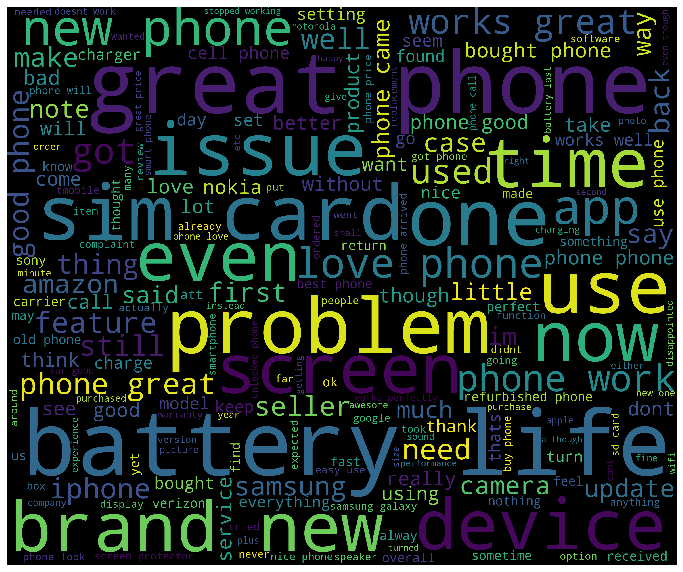

In [35]:
#Overall reviews
review_word_cloud(valid_cellphone_data["review"])

1. Users are using words like great, love, brand new, works great for positive experiences, while
2. Users are using words like issue, problem, bad, still for negative experiences.

#### Why are users giving lower ratings ? What issues are users facing? 
Let us explore the reviews with lower ratings for the top two popular brands (Samsung and Apple) which will help them in improving their user satisfaction.

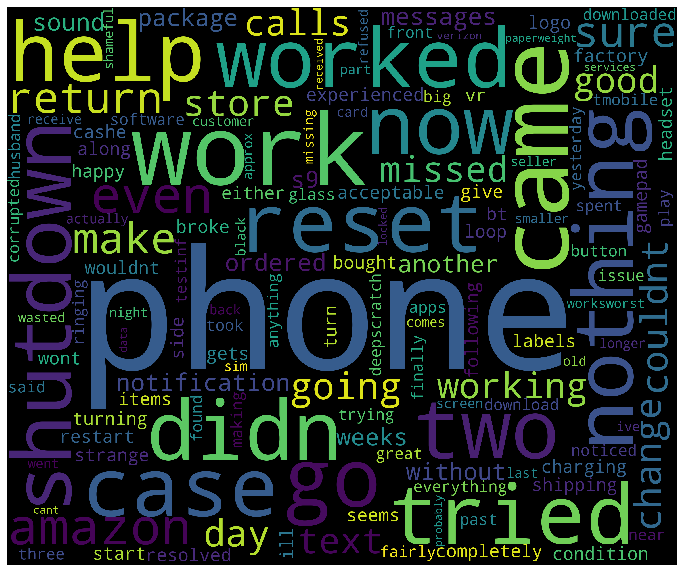

In [40]:
#Samsung reviews
samsung_data = valid_cellphone_data[(valid_cellphone_data["brand"] == "Samsung") & (valid_cellphone_data["product_rating"] < 1.5)]
review_word_cloud(samsung_data["review"])

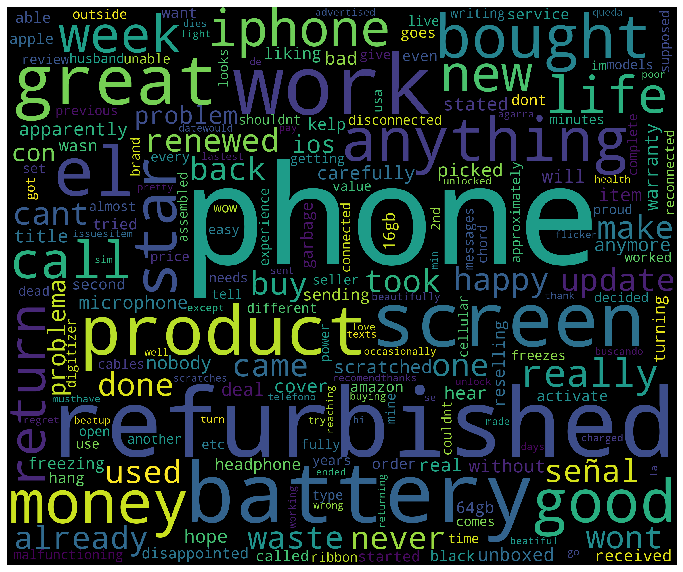

In [45]:
#Apple reviews
apple_data = valid_cellphone_data[(valid_cellphone_data["brand"] == "Apple") & (valid_cellphone_data["product_rating"] < 2.5)]
review_word_cloud(apple_data["review"])

1. Samsung needs to work on: phone shutdown issue, returns, sound, phone reset, overall working and restart
2. Apple needs to work on: battery, refurbished issues, scratches, screen issues, returns, sending correct models

#### Why are users giving higher ratings ? What is making users happy?
Again we will explore the reviews with higher ratings for the top two popular brands (Samsung and Apple).

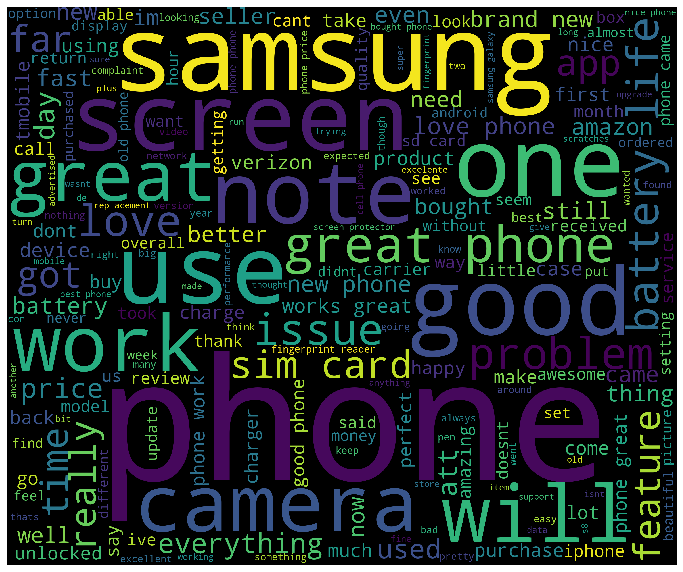

In [51]:
#Samsung reviews
samsung_data = valid_cellphone_data[(valid_cellphone_data["brand"] == "Samsung") & (valid_cellphone_data["product_rating"] > 4.0)]
review_word_cloud(samsung_data["review"])

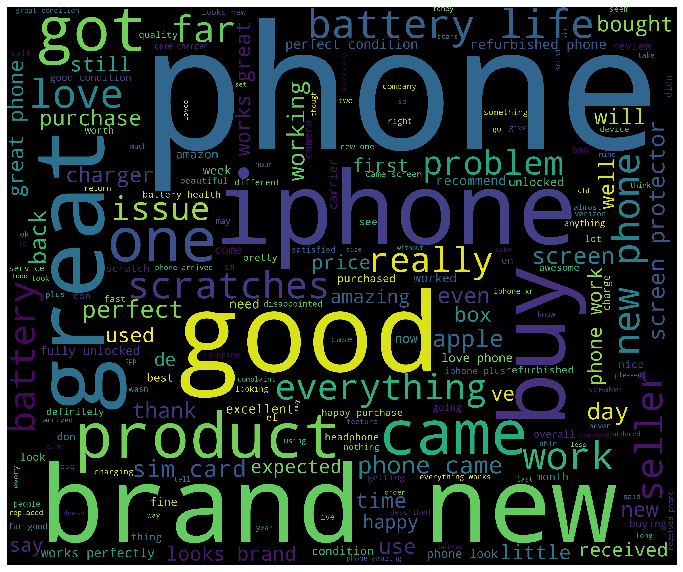

In [52]:
#Apple reviews
apple_data = valid_cellphone_data[(valid_cellphone_data["brand"] == "Apple") & (valid_cellphone_data["product_rating"] > 4.0)]
review_word_cloud(apple_data["review"])

Samsung users are happy with the overall phone, camera, features, screen and Apple users are satisfied with the overall product.

### Popular Review Words
Are overall reviews positive or negative? Let us look at the overall review words.

In [31]:
#English stop words will be removed
cv = CountVectorizer(stop_words = 'english')

#It will map every review to vocabulary(tokens) where reviews are rows and tokens are columns. It will return a matrix of words and corresponding 1 or 0
words = cv.fit_transform(valid_cellphone_data["review"])

#Vector containing sum all columns to get the total count for each word
sum_words = words.sum(axis=0)

#sort a list of tuples that contain the word and their occurrence in the reviews
words_freq = [(word, sum_words[0, count]) for word, count in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

#Convert to a dataframe
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency = frequency.head(20)

#Plot top 20 words
frequency_bar = go.Bar(x = frequency["word"], y = frequency["freq"])
layout = go.Layout(title = "TOP 20 FREQUENT WORDS", yaxis_title = "Word Count")
fig = go.Figure(frequency_bar,layout)
iplot(fig)

Majority of popular 20 frequent words are positive.

### Brand-wise Review Rating
Which cell phone brand has overall good user experiences?

In [116]:
#Plot box chart for the ratings for each brand
fig = go.Figure()
fig.add_trace(go.Box(x = valid_cellphone_data["brand"], y = valid_cellphone_data["review_rating"], marker_color = 'lightseagreen'))
fig.show()

Xiaomi has highest rating among all the brands. We can see that Mototola, Samsung and ASUS have most of the ratings above 3, while brands like Nokia, Sony, Apple and Google have ratings distributed from 2 to 5.

### Date-wise Review Count
How are the review counts spread out from 2010 to 2019?

In [117]:
#Select date-wise review count
date_data = valid_cellphone_data.groupby(["review_date"], as_index=False)["review_rating"].count()#.plot()

#Plot date-wise review count
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_data["review_date"], y=date_data["review_rating"], mode='lines+markers',
                    name='lines+markers'))
fig.update_layout(title='DATE-WISE REVIEW COUNT', yaxis_title = "Count")

Review count has consistently increased from 2010 to August 2019 and reduced after that. Maximum number of reviews are seen in July 2019.


### Predicting Rating Based on Reviews

#### Tokening the Data With spaCy
1. Create tokenizer function to strip information we don’t need, like stopwords and punctuation, from each review. Removing stopwords helps us eliminate noise and distraction from our text data, and also speeds up the time analysis takes.
2. Import the English models we need from spaCy and Python’s string module.
3. Create a tokenizer function that accepts a sentence as input and processes the sentence into tokens, performing lemmatization(changing words to their root forms(lemma)), lowercasing, and removing stop words.

In [118]:
#Load English tokenizer, tagger, parser and word vectors
nlp = spacy.load('en')

#Import stop words from English language
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

#Create function to strip information we don’t need, like stopwords and punctuation, from each review
def review_tokenizer(sentence):
    #Create token object, which is used to create documents with linguistic annotations
    mytokens = parser(sentence)

    #Lemmatizing each token and converting each token into lowercase, if it is a personal pronoun, don't lemmatize, just convert to lowercase
    mytokens = [token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_ for token in mytokens]

    # Removing stop words
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]

    # return preprocessed list of tokens
    return mytokens

To convert our text into numerical labels, we will use the Bag of Words technique. It converts text into the matrix of occurrence of words within given text. It focuses on whether given words are present or not in the text, and generates a matrix referred to as a BoW matrix or a document term matrix.

We will use TF-IDF (stands for Term-Frequency-Inverse-Document Frequency). It weights down the common words occuring in almost all the documents and give more importance to the words that appear in a subset of documents. TF-IDF works by penalising these common words by assigning them lower weights while giving importance to some rare words in a particular document.

In [119]:
#The features we want to analyze
X = valid_cellphone_data['review'] 

#The labels we want to test against
ylabels = valid_cellphone_data['review_rating'] 

#Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

We will use four models: Logistic Regression, Random Forest, MultinomialNB and LinearSVC and compare the accury to select the best model.

In [120]:
#List of classifiers
classifiers = [LogisticRegression(), RandomForestClassifier(), MultinomialNB(), LinearSVC()]
  
#This vectorizer breaks text into single words and bi-grams and then calculates the TF-IDF representation
tfidf_vector = TfidfVectorizer(tokenizer = review_tokenizer, ngram_range=(1,2)).fit(X_train)

#Now we have tokenized matrix of reviews
X_train_vectorized = tfidf_vector.transform(X_train)

#Let us see the prediction accuracy for each classifier
for classifier in classifiers:
    model = classifier
    
    #Fit the model on the vectorized matrix
    model.fit(X_train_vectorized, y_train)
    
    #Predict the rating
    predicted = model.predict(tfidf_vector.transform(X_test))
   
    #Calculate error between actual values and predicted values
    mse = mean_squared_error(y_test, predicted)
    rmse = np.sqrt(mse)
    print ("RMSE :", rmse)
    accuracy = accuracy_score(y_test, predicted)
    print("Accuracy : %.2f%%" % (accuracy * 100.0))

RMSE : 1.140591337491962
Accuracy : 71.80%
RMSE : 1.3059283786136158
Accuracy : 69.36%
RMSE : 1.721985115412239
Accuracy : 61.76%
RMSE : 1.056009245291739
Accuracy : 72.86%


We got the best accuracy using Linear SVC Model.

### Conclusion
We looked at the cell phone reviews which will help us make a better decision when we buy a new cellphone next time and also help different brands to understand what their users feel and make improvements to increase user satisfaction. We found out that:

1. Samsung and Apple are the two most popular cell phone brands. Xiaomi has highest rating among all the brands. 
2. Samsung needs to work on issues like phone shutdown, returns, sound, phone reset, overall working and restart. Samsung users are happy with the overall phone, camera, features, screen.
3. Apple needs to work on battery, refurbished model issues, scratches, screen issues, returns, sending correct models. Apple users are satisfied with the overall product.
4. Mototola, Samsung and ASUS have most of the ratings above 3, while brands like Nokia, Sony, Apple and Google have ratings distributed from 2 to 5. Xiaomi has highest rating among all the brands.
5. Linear SVC Model can be used to predict ratings based on reviews with an accuracy of 72%.